# Single Spectrum Analysis (SSA)

Illustration de la méthode [SSA](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) pour les séries temporelles appliquée à la détection de points aberrants. La méthode est décrite dans [Singular Spectrum Analysis: Methodology and Comparison](http://perso.ens-lyon.fr/patrick.flandrin/hassani.pdf). Voir aussi [Automated outlier detection in Singular Spectrum Analysis](https://www.statistics.gov.hk/wsc/CPS204-P35-S.pdf).

## Une série articielle

On introduit quelques points aberrants, pour le reste, elle suit le modèle $y_t = \frac{9}{10} y_{t-2} + \epsilon_t + a_t$ où $a_t$ est le bruit aberrant qui survient quelques fois.

In [1]:
import numpy.random as rnd
import numpy

N = 2000
bruit1 = rnd.normal(size=(N,))
temps = numpy.arange(N)
bruit1[:5], temps[:5]

(array([-0.24857848, -2.14896109,  0.81023497,  1.85981186, -0.04023266]),
 array([0, 1, 2, 3, 4]))

On crée un bruit aberrant.

In [2]:
import random

bruit2 = numpy.zeros((N,))
for i in range(0, 10):
    h = random.randint(0, N - 1)
    bruit2[h] = rnd.normal() + 10

In [3]:
serie = []
y = 10
for i in range(N // 2 + 100):
    serie.append(y + bruit1[i] + 0.0004 * temps[i] + bruit2[i])
    if i > 30:
        y = 0.9 * serie[-2]
Y = numpy.array(serie[-1000:])
Y[:5]

array([ 0.00542873,  3.19959898, -0.04290419,  3.18763969, -1.60007673])

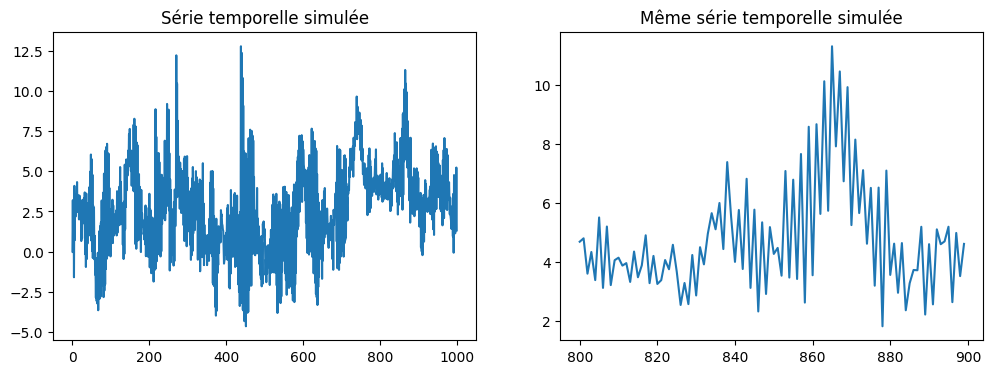

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(numpy.arange(len(Y)), Y)
ax[1].plot(numpy.arange(800, 900), Y[800:900])
ax[0].set_title("Série temporelle simulée")
ax[1].set_title("Même série temporelle simulée");

## Autocorrélations

L'autocorrélogramme est définie par la série $cor(Y_t, Y_{t-d})_d$. On le calcule sur la série nettoyée de sa tendance.

In [5]:
from pandas import DataFrame

df = DataFrame(dict(Y=Y))
df.head()

,Y
0,0.005429
1,3.199599
2,-0.042904
3,3.187640
4,-1.600077


In [6]:
from statsmodels.tsa.tsatools import detrend

df["notrend"] = detrend(df.Y)
df.head()

,Y,notrend
0,0.005429,-1.438347
1,3.199599,1.753363
2,-0.042904,-1.491601
3,3.187640,1.736482
4,-1.600077,-3.053695


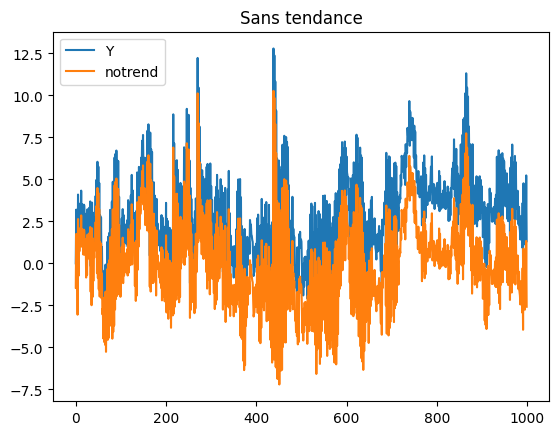

In [7]:
ax = df.plot()
ax.set_title("Sans tendance");

L'autocorrélogramme à proprement parler.

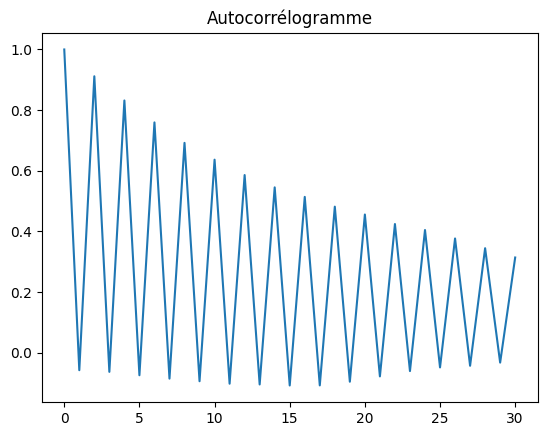

In [8]:
from statsmodels.tsa.stattools import acf

cor = acf(df.notrend)
fig, ax = plt.subplots(1, 1)
ax.plot(cor)
ax.set_title("Autocorrélogramme");

Etant donnée que la série $Y_t$ dépend de $Y_{t-2}$, on observe un pic pour $cor(Y_t, Y_{t-2})_d$ et pour tous les $d$ pairs. $cor(Y_t, Y_{t-4}) \sim cor(Y_t, Y_{t-2})^2$. On enlève ces effets récursifs en calculant l'autocorrélogramme partiel qui correspond à l'estimation des coefficients d'un [modèle autorégressif](https://fr.wikipedia.org/wiki/Processus_autor%C3%A9gressif) infini.

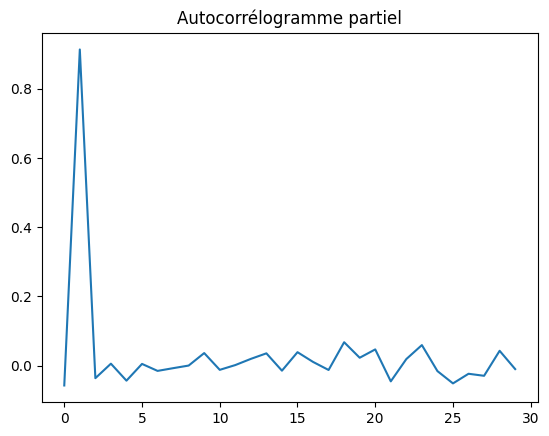

In [9]:
from statsmodels.tsa.stattools import pacf

pcor = pacf(df.notrend)
fig, ax = plt.subplots(1, 1)
ax.plot(pcor[1:])
ax.set_title("Autocorrélogramme partiel");

## SSA

Ou Singular Spectrum Analysis. La méthode part de la matrice des séries décalées qu'on décompose avec la méthode SVD ou [Singular Value Decomposition](https://fr.wikipedia.org/wiki/D%C3%A9composition_en_valeurs_singuli%C3%A8res).

In [10]:
def lagged_ts(serie, lag):
    dim = serie.shape[0]
    res = numpy.zeros((dim - lag + 1, lag))
    for i in range(lag):
        res[:, i] = serie[i : dim - lag + i + 1]
    return res


lagged_ts(Y, 3)

array([[ 0.00542873,  3.19959898, -0.04290419],
       [ 3.19959898, -0.04290419,  3.18763969],
       [-0.04290419,  3.18763969, -1.60007673],
       ...,
       [ 1.13700254,  4.06081016,  1.89449208],
       [ 4.06081016,  1.89449208,  5.23733857],
       [ 1.89449208,  5.23733857,  1.32045675]])

In [11]:
lag = lagged_ts(Y, 60)
lag.shape

(941, 60)

In [12]:
from numpy.linalg import svd

# u @ numpy.diag(s) @ vh
u, s, vh = svd(lag)

In [13]:
u.shape, s.shape, vh.shape

((941, 941), (60,), (60, 60))

In [14]:
d = numpy.zeros((941, 60))
d[:60, :60] = numpy.diag(s)

In [15]:
(u @ d @ vh).shape

(941, 60)

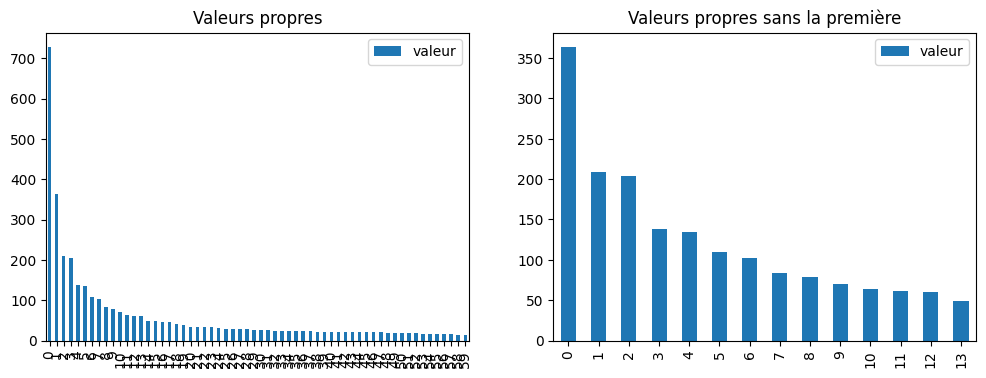

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
DataFrame(dict(valeur=s)).plot(kind="bar", ax=ax[0])
DataFrame(dict(valeur=s[1:15])).plot(kind="bar", ax=ax[1])
ax[0].set_title("Valeurs propres")
ax[1].set_title("Valeurs propres sans la première");

Je me représente la méthode SVD comme une façon de projeter des vecteurs sur l'espace vectoriel constitué des premiers vecteurs propres, à chaque dimension supplémentaire, c'est comme une pièce du puzzle qui s'assemble jusqu'à recomposer l'ensemble. Ce qu'on peut voir aussi comme ceci :

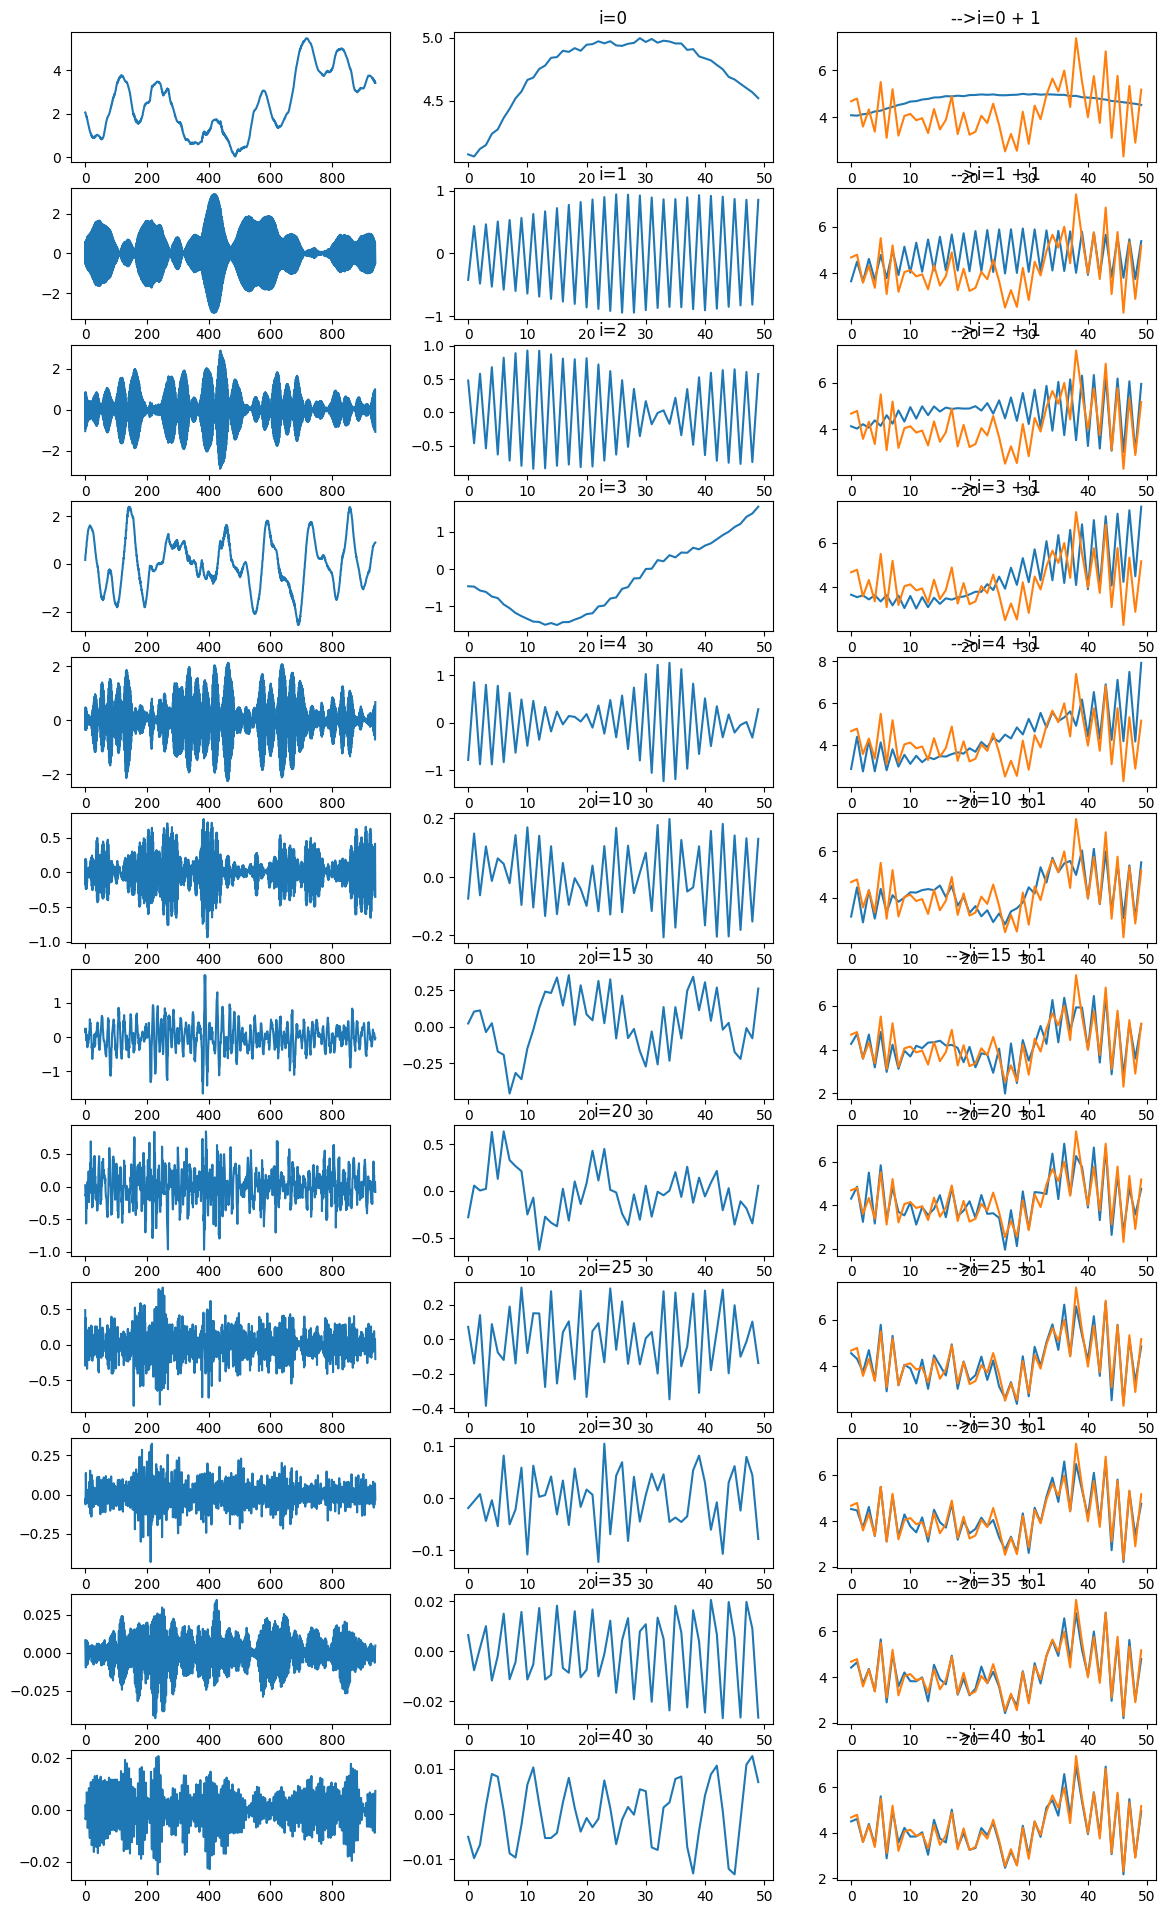

In [17]:
np = 12
fig, ax = plt.subplots(np, 3, figsize=(14, np * 2))
for n in range(np):
    i = n if n < 5 else n * 5 - 15
    d = numpy.zeros((941, 60))
    d[i, i] = s[i]
    X2 = u @ d @ vh
    pos = 0  # X2.shape[1] - 1

    # série reconstruites avec un axe
    ax[n, 0].plot(X2[:, pos])
    ax[n, 1].set_title("i=%d" % i)
    # série reconstruites avec un axe
    ax[n, 1].plot(X2[800:850, pos])
    ax[n, 1].set_title("i=%d" % i)

    d = numpy.zeros((941, 60))
    d[: i + 1, : i + 1] = numpy.diag(s[: i + 1])
    X2 = u @ d @ vh
    ax[n, 2].plot(X2[800:850, pos])
    ax[n, 2].plot(Y[800:850])
    ax[n, 2].set_title("-->i=%d + 1" % i)

## La prédiction

On veut prédire $Y_{t+1}$. L'idée consiste à appliquer la méthode en considérent $Y_{t+1}$ égale à $Y_t$ puis à remplacer cette prédiction par la valeur de la série reconstruite. On peut même prédire à un horizon plus grand que la valeur suivante.

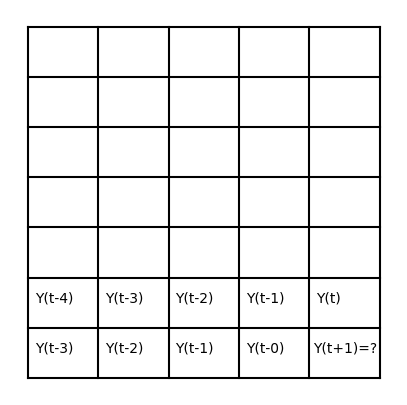

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(0, 8):
    ax.plot([0, 5], [i, i], "k-")
    if i < 6:
        ax.plot([i, i], [0, 7], "k-")
    if i < 4:
        ax.text(i + 0.1, 1.5, "Y(t-%d)" % (4 - i))
        ax.text(i + 0.1, 0.5, "Y(t-%d)" % (3 - i))
ax.text(4.1, 1.5, "Y(t)")
ax.text(4.05, 0.5, "Y(t+1)=?")
plt.axis("off");

## Les points aberrants

On repère les points aberrants avec l'une méthode de son choix sur la série reconstruite.

In [19]:
d = numpy.zeros((941, 60))
for i in range(0, 30):
    d[i, i] = s[i]
X2 = u @ d @ vh

In [23]:
from sklearn.covariance import EllipticEnvelope

env = EllipticEnvelope(support_fraction=0.9)
env.fit(X2[:, :30])

EllipticEnvelope(support_fraction=0.9)

L'idéal serait d'utiliser une méthode basée sur une ACP. Le plus proche reste le modèle gaussien avec [EllipticEnvelope](http://scikit-learn.org/dev/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope).

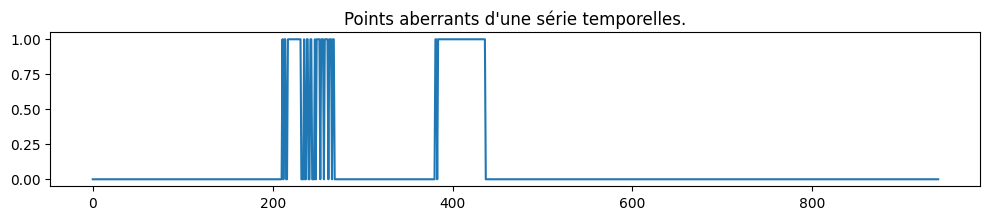

In [24]:
out = env.predict(X2[:, :30])

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot((1 - out) / 2, "-")
ax.set_title("Points aberrants d'une série temporelles.");

On observe des plages contiguës. Cela signifie que d'une valeur aberrante contamine des vecteurs décalées consécutifs de la série $Y$. Il ne reste plus qu'à repérer la valeur incriminée.

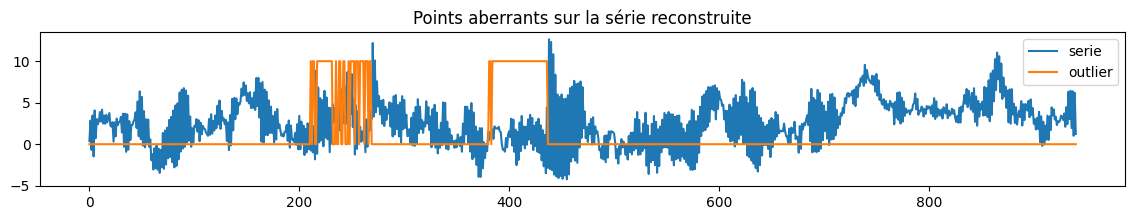

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
ax.plot(X2[:, 0], label="serie")
ax.plot((1 - out) * 5, "-", label="outlier")
ax.set_title("Points aberrants sur la série reconstruite")
ax.legend();

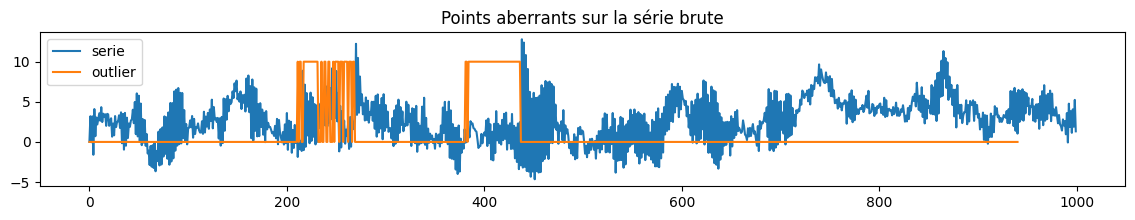

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
ax.plot(Y, label="serie")
ax.plot((1 - out) * 5, "-", label="outlier")
ax.set_title("Points aberrants sur la série brute")
ax.legend();

Ce qui a l'air de correspondre à la fin des grandes plages. On recommence avec la probabilité d'être un outlier.

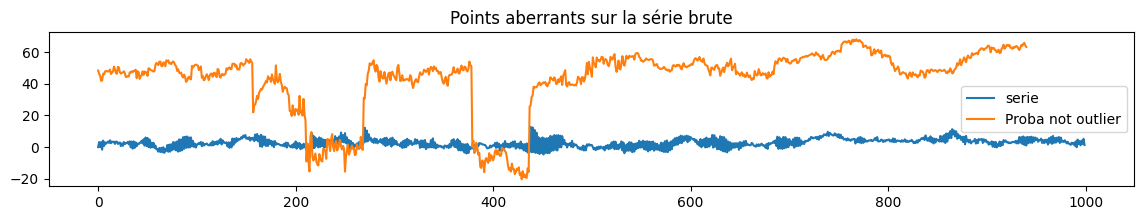

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
outp = env.decision_function(X2[:, :30])
ax.plot(Y, label="serie")
ax.plot(outp, "-", label="Proba not outlier")
ax.set_title("Points aberrants sur la série brute")
ax.legend();